# Processing OISST Data with Python 3.6 & Local Netcdf Files

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os

#Suppress divide by NA error
np.seterr(divide='ignore', invalid='ignore', )

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Loading Pre-downloaded netcdf files

In [2]:
#Generate list of file names from start and end + 1
my_years = np.arange(1981, 2012, 1)
nc_files = []
for i in my_years:
    nc_files.append("sst.day.mean." + str(i) + ".v2.nc")
    

In [3]:
#Check them
print(nc_files[25:31])

['sst.day.mean.2006.v2.nc', 'sst.day.mean.2007.v2.nc', 'sst.day.mean.2008.v2.nc', 'sst.day.mean.2009.v2.nc', 'sst.day.mean.2010.v2.nc', 'sst.day.mean.2011.v2.nc']


In [4]:
# # Lazy Load Metadata for each
# nc_meta = []
# for filename in nc_files:
#     nc_meta.append(xr.open_dataset(filename))

## Combine the netcdf files into a single dataset with netCDF4.MFDataset

In [5]:
#ensure we're in correct directory
#os.chdir("/Users/akemberling/Documents/oisst_mainstays/annual_oisst")
os.chdir("/home/jovyan/oisst_mainstays/annual_oisst") #when working in okn-nettwork-graph container

sst_dataset = netCDF4.MFDataset(nc_files)
sst_dataset

<class 'netCDF4._netCDF4.MFDataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.5
    title: NOAA High-resolution Blended Analysis: Daily Values using AVHRR only
    institution: NOAA/NCDC
    source: NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment: Reynolds, et al., 2007: Daily High-Resolution-Blended Analyses for Sea Surface Temperature. J. Climate, 20, 5473-5496.  Climatology is based on 1971-2000 OI.v2 SST, Satellite data: Navy NOAA17 NOAA18 AVHRR, Ice data: NCEP ice.
    history: Thu Aug 24 13:34:17 2017: ncatted -O -a References,global,d,, sst.day.mean.1981.v2.nc
Version 1.0
    references: https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html
    dataset_title: NOAA Daily Optimum Interpolation Sea Surface Temperature
    dimensions = ('time', 'lat', 'lon')
    variables = ('time', 'lat', 'lon', 'sst')
    groups = ()

## Combining them with xarray

In [6]:
#ensure we're in correct directory
#os.chdir("/Users/akemberling/Documents/oisst_mainstays/annual_oisst")
os.chdir("/home/jovyan/oisst_mainstays/annual_oisst") #when working in okn-nettwork-graph container

#clim = xr.open_mfdataset('*.nc', parallel = True, combine = 'by_coords')
clim = xr.open_mfdataset(nc_files, parallel = False, combine = "by_coords")
clim

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 11079)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2011-12-31
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(122, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

## Processing Overall Climatology

In [12]:
#sst_clim = clim['sst'].mean('time', keep_attrs=True)

### Plotting Overall Climatology

In [1]:
# fig = plt.figure(figsize=[12,5])

# ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))

# sst_clim.plot.contourf(ax=ax,
#                    levels=np.arange(0, 30, 1.5),
#                    extend='max',
#                    transform=ccrs.PlateCarree(),
#                    cbar_kwargs={'label': sst_clim.units})
# ax.coastlines()

# plt.show()

# Daily Climatologies
We want to group them by the day of the year then calculate the mean of every cell. The issue is ds.time.dayofyear switches between 365 & 366 days, meaning any day from march through the end of december is going to shift by 1 every leap year.

In [7]:
clim['sst'].groupby('time.dayofyear')

DataArrayGroupBy, grouped over 'dayofyear' 
366 groups with labels 1, 2, 3, 4, 5, ..., 363, 364, 365, 366.

## Make New Ordinal Index for Day of Year
The way around the leap-year issue is to make a new ordinal day vector to which puts all years on the same 366 day scale ensuring that March 1st for example is always the 61st day, even on non-leap-years.

In [8]:
not_leap_year = ~clim.indexes['time'].is_leap_year

march_or_later = clim.time.dt.month >= 3

ordinal_day = clim.time.dt.dayofyear

# Test Understanding

#TRUE/FALSE to indicate that its not a leap year, and its after February
#(not_leap_year & march_or_later) 

#Output is the original ordinal day + 1 if the condition is met
#ordinal_day + (not_leap_year & march_or_later) #Adding a TRUE is the same as adding 1

Modified ordinal day takes the original day of year value. Then adds 1 if the conditions are met that it is not a leap year and it is after February.

In [9]:
modified_ordinal_day = ordinal_day + (not_leap_year & march_or_later)

modified_ordinal_day = modified_ordinal_day.rename('modified_ordinal_day')

Now use that as the grouping index

In [10]:
daily_clims = clim['sst'].groupby(modified_ordinal_day).mean('time', keep_attrs=True)
daily_clims

<xarray.DataArray 'sst' (modified_ordinal_day: 366, lat: 720, lon: 1440)>
dask.array<stack, shape=(366, 720, 1440), dtype=float32, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * modified_ordinal_day  (modified_ordinal_day) int64 1 2 3 4 ... 364 365 366
Attributes:
    long_name:     Daily Sea Surface Temperature
    units:         degC
    valid_range:   [-3. 45.]
    precision:     2.0
    dataset:       NOAA High-resolution Blended Analysis
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Observations
    actual_range:  [-1.8  34.82]

## Plotting a Daily Climatology
Define a function to plot a given day of the year. This will let me debug if it is actually calculating them correctly

In [11]:
def plot_yearday_sst(day_year = 1):
    
    daily_sst = daily_clims.sel(modified_ordinal_day = day_year)
    
    fig = plt.figure(figsize=[12,5])

    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
    fig.suptitle('Daily SST Climatology for the ' + str(day_year) + 'th day of the year.', fontsize=16)

    daily_sst.plot.contourf(ax=ax,
                       levels=np.arange(0, 30, 1.5),
                       extend='max',
                       transform=ccrs.PlateCarree(),
                       cbar_kwargs={'label': daily_sst.units})
    ax.coastlines()

    plt.show()

### Test 1: Mid-year
SST Climatology for the 180th day of the year

In [ ]:
plot_yearday_sst(day_year = 180)

### Test 2: Jan 1
SST Climatology for January 1st

/Users/akemberling/opt/anaconda2/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


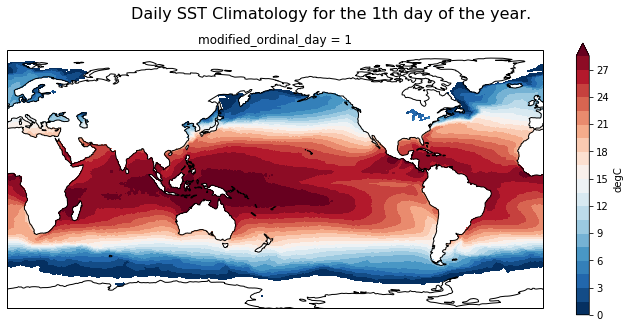

In [28]:
plot_yearday_sst(day_year = 1)

### Test 3: Leap Year
Does it take less time to do leap years?

/Users/akemberling/opt/anaconda2/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


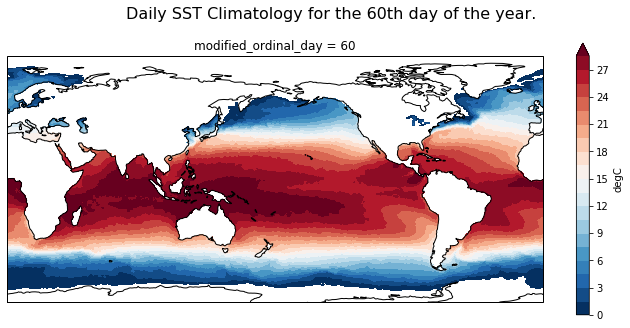

In [22]:
plot_yearday_sst(day_year = 60)

# Exporting Daily Climatologies

`daily_clims` is currently of type "DataArray". We want to convert it to a DataArray Dataset. DataArray Datasets are dict-like containers of labeled arrays (DataArray objects) with aligned dimensions. It is designed as an in-memory representation of the data model from the netCDF file format.

In this example there is only one variable `sst`, which we will want to change to make sure the attributes accurately describe it as a climatology.

### Export Climatology Array

In [14]:
#Note that the attributes exist here.
daily_clims.attrs

{'long_name': 'Daily Sea Surface Temperature',
 'units': 'degC',
 'valid_range': array([-3., 45.], dtype=float32),
 'precision': 2.0,
 'dataset': 'NOAA High-resolution Blended Analysis',
 'var_desc': 'Sea Surface Temperature',
 'level_desc': 'Surface',
 'statistic': 'Mean',
 'parent_stat': 'Individual Observations',
 'actual_range': array([-1.8 , 34.82], dtype=float32)}

In [15]:
#Export the array
daily_clims.to_netcdf('/Users/akemberling/Documents/oisst_mainstays/daily_climatologies/daily_clims_82to2011.nc')

/Users/akemberling/opt/anaconda2/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


### Building Dataarray Dataset

In [53]:
#Make dataarray dataset to try fixing attributes
daily_clims_ds = daily_clims.to_dataset()
daily_clims_ds

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, modified_ordinal_day: 366)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * modified_ordinal_day  (modified_ordinal_day) int64 1 2 3 4 ... 364 365 366
Data variables:
    sst                   (modified_ordinal_day, lat, lon) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

## Adding/Modifying Attributes
Attributes are added using dictionaries that serve as metadata for the array datasets. The current dataarray dataset structure does not contain attributes so we'll need to add them

In [54]:
#Data Array Dataset Attributes
daily_clims_ds.attrs

{}

In [55]:
clim.attrs

{'Conventions': 'CF-1.5',
 'title': 'NOAA High-resolution Blended Analysis: Daily Values using AVHRR only',
 'institution': 'NOAA/NCDC',
 'source': 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/',
 'comment': 'Reynolds, et al., 2007: Daily High-Resolution-Blended Analyses for Sea Surface Temperature. J. Climate, 20, 5473-5496.  Climatology is based on 1971-2000 OI.v2 SST, Satellite data: Navy NOAA17 NOAA18 AVHRR, Ice data: NCEP ice.',
 'history': 'Thu Aug 24 13:34:17 2017: ncatted -O -a References,global,d,, sst.day.mean.1981.v2.nc\nVersion 1.0',
 'references': 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html',
 'dataset_title': 'NOAA Daily Optimum Interpolation Sea Surface Temperature'}

In [56]:
#Change the Attributes for the dataset
daily_clims_ds.attrs['title']         = '30-Year sea surface temperature climatology from NOAA OISST SST ata'
daily_clims_ds.attrs['institution']   = 'Gulf of Maine Research Institute'
daily_clims_ds.attrs['source']        = 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/'
daily_clims_ds.attrs['comment']       = 'Climatologies represent mean SST for the years 1982-2011'
daily_clims_ds.attrs['history']       = 'Climatologies calculated 3/2/2020'
daily_clims_ds.attrs['references']    = 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html'
daily_clims_ds.attrs['dataset_title'] = 'GMRI 30-Year Climatology - OISST'
daily_clims_ds.attrs

{'title': '30-Year sea surface temperature climatology from NOAA OISST SST ata',
 'institution': 'Gulf of Maine Research Institute',
 'source': 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/',
 'comment': 'Climatologies represent mean SST for the years 1982-2011',
 'history': 'Climatologies calculated 3/2/2020',
 'references': 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html',
 'dataset_title': 'GMRI 30-Year Climatology - OISST'}

In [57]:
# Attributes for individual variables
daily_clims_ds['sst'].attrs

{'long_name': 'Calendar-day Sea Surface Temperature Climatology',
 'units': 'degC',
 'valid_range': array([-3., 45.], dtype=float32),
 'precision': 2.0,
 'dataset': 'NOAA High-resolution Blended Analysis',
 'var_desc': 'Sea Surface Temperature',
 'level_desc': 'Surface',
 'statistic': 'Mean',
 'parent_stat': 'Individual Observations',
 'actual_range': array([-1.8 , 34.82], dtype=float32)}

## Save to Disk
Now that the attributes/metadata is set, we just need to save them to disk

In [58]:
daily_clims_ds.to_netcdf('/Users/akemberling/Documents/oisst_mainstays/daily_climatologies/daily_clims_82to2011.nc')

PermissionError: [Errno 13] Permission denied: b'/Users/akemberling/Documents/oisst_mainstays/daily_climatologies/daily_clims_82to2011.nc'